In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
import torch.optim as optim
import torch

In [3]:
df = pd.read_csv("combined.csv", index_col=0)

In [37]:
class Tester:
    def __init__(self, data, metrics, target_column="Gold_Close", split_ratio=0.2):
        """
        Initialize the Tester class with the dataset and metrics.
        
        :param data: The dataset (assumed to be a DataFrame or similar structure).
        :param metrics: A list of metrics functions to evaluate the model.
        """
        self.data = data
        self.split_ratio = split_ratio
        self.metrics = metrics
        self.target_column = target_column

        self.preprocess_data()

        self.X_train, self.y_train, self.X_test, self.y_test = None, None, None, None
        self.split_data(split_ratio=self.split_ratio)
    
    def split_data(self, split_ratio=0.2, random_state=42):
        """
        Split the data into training and testing sets, by performing a determinsitic continous split
        
        :param target_column: The column name in the dataset that contains the target variable.
        :param test_size: The proportion of the dataset to include in the test split.
        :param random_state: Controls the shuffling applied to the data before applying the split.
        """
        split_index = int(len(self.data) * (1 - split_ratio))
        train_data = self.data[:split_index]
        test_data = self.data[split_index:]

        self.X_train = train_data.drop(columns=[self.target_column])
        self.y_train = train_data[[self.target_column]]

        self.X_test = test_data.drop(columns=[self.target_column])
        self.y_test = test_data[[self.target_column]]

    def preprocess_data(self):
        """
        Apply preprocessing to the data (e.g., Min-Max scaling).
        """
        scaler = MinMaxScaler()  # Initialize the scaler

        X = self.data.drop(columns=[self.target_column])
        y = self.data[[self.target_column]]
        
        # Apply Min-Max Scaling to features
        X_scaled = scaler.fit_transform(X)
        
        self.data_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=self.data.index)
        self.data_scaled[self.target_column] = y

    def _train_model(self, model, epochs=20):
        X_train, y_train = torch.tensor(self.X_train.to_numpy()), torch.tensor(self.y_train.to_numpy())
        # Can access testing data if needed in the same manner

        assert isinstance(model, nn.Module)

        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.05)

        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            optimizer.step()
        
            if (epoch+1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

        return

    def _predict(self, model):
        X_test = torch.tensor(self.X_test.to_numpy())
        # Assuming model is pytorch model
        assert isinstance(model, nn.Module)
        model.eval()
        return model(X_test)
        
    
    def run(self, model):
        """
        Run the model on the training data and evaluate it on the test data using the provided metrics.
        
        :param model: The machine learning model to train and evaluate.
        :return: A pandas DataFrame containing the results for each metric.
        """
    
        # Train the model
        if hasattr(model, "fit") and callable(model.fit):
            model.fit(self.X_train, self.y_train)
        else:
            self._train_model(model)

        
        # Predict on the test set
        if hasattr(model, "predict") and callable(model.predict):
            y_pred = model.predict(self.X_test)
        else:
            y_pred = self._predict(model)
        
        # Evaluate using the provided metrics
        results = {}
        for metric in self.metrics:
            metric_name = metric.__name__
            results[metric_name] = metric(self.y_test, y_pred)
        
        # Return the results as a pandas DataFrame
        return pd.DataFrame([results])
    
    def run_multiple(self, models):
        """
        Run multiple models using the run function and return the results in a DataFrame.
        
        :param models: A list of tuples, where each tuple contains a model and its name.
        :return: A pandas DataFrame with each row corresponding to a model's evaluation results.
        """
        results_list = []
        
        for model_name, model in models:
            print(f"Running model: {model_name}")
            result = self.run(model)
            result.insert(0, 'Model', model_name)  # Insert the model name as the first column
            results_list.append(result)
        
        # Concatenate all results into a single DataFrame
        return pd.concat(results_list, ignore_index=True).set_index("Model")    

In [17]:
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, root_mean_squared_error

# tester = Tester(df, metrics=[mean_squared_error, r2_score, root_mean_squared_error], split_ratio=0.2)

In [40]:
# Benchmark (taking mean of the data)

class Benchmark:
    def __init__(self):
        self.mean = None
    
    def fit(self, X, y):
        self.mean = y.mean()
    
    def predict(self, X):
        return np.full((len(X), 1), self.mean)

In [42]:
tester.run_multiple(models=[
    ("Benchmark", Benchmark()),
    ("Linear Regression", LinearRegression()),
    ("XGBoost", XGBRegressor(
                            colsample_bytree=0.7,
                            learning_rate=0.05,
                            n_estimators=50,
                            max_depth=8,
                            subsample=0.7,
                            min_child_weight=4,
                            ))
])

Running model: Benchmark
Running model: Linear Regression
Running model: XGBoost


,mean_squared_error,r2_score,root_mean_squared_error
Model,,,
Benchmark,318033.573129,-6.708696,563.944654
Linear Regression,200956.727461,-3.870914,448.281973
XGBoost,254348.824417,-5.165066,504.330075


In [116]:
df.describe()

,S&P500_Close,Crude Oil_Close,Silver_Close,Iron_Close,NIFTY 50_Close,NYSE Composite_Close,Chinese Yuan_Close,Euro_Close,VIX_Close,Inflation_Close,Gold_Close
count,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000
mean,2740.063085,71.691089,21.994752,107.468951,10925.609322,12087.970280,0.151919,1.185838,18.110450,2.407092,1537.221272
std,1157.291120,22.142809,6.350542,38.737764,5036.868253,2965.730606,0.007826,0.112203,6.995912,0.905583,309.194763
min,1099.229980,-37.630001,11.735000,38.540001,4544.200195,6571.450195,0.136467,0.959619,9.140000,0.499000,1050.800049
25%,1863.240021,52.410000,16.765501,74.147501,6694.687378,10055.099854,0.145261,1.097538,13.430000,1.780000,1273.400024
50%,2475.955078,72.035000,20.419000,107.070000,9667.024902,11699.810059,0.152763,1.145646,16.270000,2.306000,1474.849976
75%,3790.087463,91.384998,25.716000,134.152496,14675.825073,14506.004883,0.158178,1.285843,20.672500,2.893000,1781.624969
max,5667.200195,123.699997,48.584000,219.770004,25010.900391,19093.480469,0.170561,1.484406,82.690002,4.988000,2511.300049


# Scaling
Variable have different scales, thus we will scale each sepreatley 

## Walk-Forward Validation

$$(\text{Batch}, \text{Window}, \text{Variables})$$

In [4]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

mm = MinMaxScaler()
ss = StandardScaler()

scaled_df = pd.DataFrame(mm.fit_transform(df), columns=df.columns)
# pd.DataFrame(mm.fit_transform(df), columns=df.columns)

In [6]:
window = 9
tscv = TimeSeriesSplit(test_size=1, n_splits=len(df)-1-(window-1), max_train_size=window)
X = []
y = []
for i, (train_index, test_index) in enumerate(tscv.split(scaled_df)):
    if i == 0:
        print("Fold", i)
        print("Train: ", train_index)
        print("Test: ", test_index)
        print()
    X.append(scaled_df.iloc[train_index].drop(columns=["Gold_Close"]).to_numpy())
    y.append(scaled_df.iloc[test_index]["Gold_Close"])

X = np.array(X)
y = np.array(y)

print(X.shape)
print(y.shape)
train_size = int(len(y) * 0.8)
train_X, test_X = X[:train_size], X[train_size:]
train_y, test_y = y[:train_size], y[train_size:]

# Convert to PyTorch tensors
train_X = torch.from_numpy(train_X).float()
train_y = torch.from_numpy(train_y).float()
test_X = torch.from_numpy(test_X).float()
test_y = torch.from_numpy(test_y).float()
print(train_X.shape)
print(train_y.shape)

print(test_X.shape)
print(test_y.shape)


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Convert data to PyTorch tensors
train_X_tensor = torch.Tensor(train_X)
train_y_tensor = torch.Tensor(train_y)
test_X_tensor = torch.Tensor(test_X)
test_y_tensor = torch.Tensor(test_y)

# Create DataLoader for batching
train_dataset = TensorDataset(train_X_tensor, train_y_tensor)
test_dataset = TensorDataset(test_X_tensor, test_y_tensor)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

Fold 0
Train:  [0 1 2 3 4 5 6 7 8]
Test:  [9]

(3479, 9, 10)
(3479, 1)


In [21]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import TimeSeriesSplit

# Define hyperparameters
window_size = 9
batch_size = 32
test_size_split = 0.2

# TimeSeriesSplit parameters
n_splits = len(df) - 1 - (window_size - 1)

# Data processing function
def prepare_data(scaled_df, window_size, target_column="Gold_Close"):
    tscv = TimeSeriesSplit(test_size=1, n_splits=n_splits, max_train_size=window_size)
    X, y = [], []

    for train_index, test_index in tscv.split(scaled_df):
        # Features: exclude the target column
        X.append(scaled_df.iloc[train_index].to_numpy())
        # Labels: include only the target column for the next day
        y.append(scaled_df.iloc[test_index][target_column].values)

    X = np.array(X)
    y = np.array(y)

    return X, y

# Split data into training and testing
def split_train_test(X, y, test_size_split):
    train_size = int(len(y) * (1 - test_size_split))
    train_X, test_X = X[:train_size], X[train_size:]
    train_y, test_y = y[:train_size], y[train_size:]

    # Convert to PyTorch tensors
    train_X = torch.from_numpy(train_X).float()
    train_y = torch.from_numpy(train_y).float()
    test_X = torch.from_numpy(test_X).float()
    test_y = torch.from_numpy(test_y).float()

    return train_X, train_y, test_X, test_y

# Dataset and DataLoader preparation
def create_dataloaders(train_X, train_y, test_X, test_y, batch_size):
    train_dataset = TensorDataset(train_X, train_y)
    test_dataset = TensorDataset(test_X, test_y)

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

# ---- Main workflow ----

# Prepare data
X, y = prepare_data(scaled_df, window_size)

# Split data into training and testing sets
train_X, train_y, test_X, test_y = split_train_test(X, y, test_size_split)

# Create DataLoaders
train_loader, test_loader = create_dataloaders(train_X, train_y, test_X, test_y, batch_size)

# Check shapes
print(f"Training X shape: {train_X.shape}")
print(f"Training y shape: {train_y.shape}")
print(f"Testing X shape: {test_X.shape}")
print(f"Testing y shape: {test_y.shape}")

Training X shape: torch.Size([2783, 9, 11])
Training y shape: torch.Size([2783, 1])
Testing X shape: torch.Size([696, 9, 11])
Testing y shape: torch.Size([696, 1])


In [41]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, requires_grad=True)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, requires_grad=True)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc1(out[:, -1, :])
        return out

# Initialize the LSTM model
input_size = X.shape[2]
hidden_size = 64
num_layers = 2
output_size = 1
model = LSTM(input_size, hidden_size, num_layers, output_size)

In [44]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


num_epochs = 80

for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item(): .5f}')

Epoch 1/80, Loss:  0.00016
Epoch 2/80, Loss:  0.00024
Epoch 3/80, Loss:  0.00045
Epoch 4/80, Loss:  0.00032
Epoch 5/80, Loss:  0.00035
Epoch 6/80, Loss:  0.00026
Epoch 7/80, Loss:  0.00048
Epoch 8/80, Loss:  0.00050
Epoch 9/80, Loss:  0.00021
Epoch 10/80, Loss:  0.00023
Epoch 11/80, Loss:  0.00066
Epoch 12/80, Loss:  0.00021
Epoch 13/80, Loss:  0.00042
Epoch 14/80, Loss:  0.00017
Epoch 15/80, Loss:  0.00015
Epoch 16/80, Loss:  0.00025
Epoch 17/80, Loss:  0.00019
Epoch 18/80, Loss:  0.00026
Epoch 19/80, Loss:  0.00019
Epoch 20/80, Loss:  0.00033
Epoch 21/80, Loss:  0.00020
Epoch 22/80, Loss:  0.00022
Epoch 23/80, Loss:  0.00088
Epoch 24/80, Loss:  0.00018
Epoch 25/80, Loss:  0.00013
Epoch 26/80, Loss:  0.00018
Epoch 27/80, Loss:  0.00053
Epoch 28/80, Loss:  0.00054
Epoch 29/80, Loss:  0.00024
Epoch 30/80, Loss:  0.00014
Epoch 31/80, Loss:  0.00019
Epoch 32/80, Loss:  0.00032
Epoch 33/80, Loss:  0.00024
Epoch 34/80, Loss:  0.00013
Epoch 35/80, Loss:  0.00011
Epoch 36/80, Loss:  0.00028
E

In [46]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        all_preds.append(outputs.cpu().numpy())
        all_labels.append(batch_y.cpu().numpy())

# Convert predictions and labels to numpy arrays
all_preds = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Calculate metrics
mse = mean_squared_error(all_labels, all_preds)
r2 = r2_score(all_labels, all_preds)
rmse = np.sqrt(mse)

# Print the results
print(f'Mean Squared Error: {mse:.4f}')
print(f'R2 Score: {r2:.4f}')
print(f'Root Mean Squared Error: {rmse:.4f}')

Mean Squared Error: 0.0006
R2 Score: 0.9691
Root Mean Squared Error: 0.0245


<Axes: >

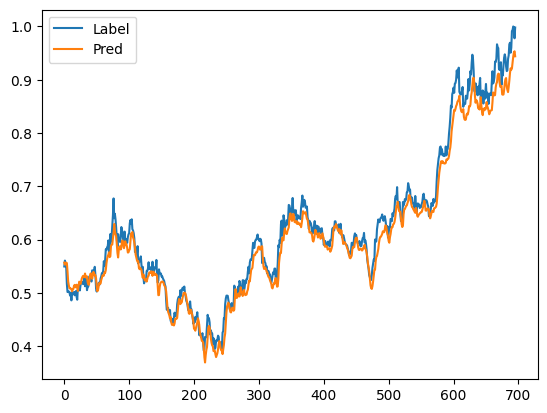

In [47]:
pd.DataFrame(np.column_stack([all_labels, all_preds]), columns=["Label", "Pred"]).plot()

In [48]:
scaled_out = pd.DataFrame(np.column_stack([test_X[:, 0, :10], all_preds]), columns=df.columns)
unscaled_out = pd.DataFrame(mm.inverse_transform(scaled_out), columns=scaled_df.columns)
gold_pred = unscaled_out["Gold_Close"]

In [49]:
scaled_out = pd.DataFrame(np.column_stack([test_X[:, 0, :10], all_labels]), columns=df.columns)
unscaled_out = pd.DataFrame(mm.inverse_transform(scaled_out), columns=scaled_df.columns)
gold_true = unscaled_out["Gold_Close"]

In [50]:
mse = mean_squared_error(gold_true, gold_pred)
r2 = r2_score(gold_true, gold_pred)
rmse = np.sqrt(mse)

# Print the results
print(f'Mean Squared Error: {mse:.4f}')
print(f'R2 Score: {r2:.4f}')
print(f'Root Mean Squared Error: {rmse:.4f}')

Mean Squared Error: 1276.0803
R2 Score: 0.9691
Root Mean Squared Error: 35.7223
